In [1]:
import os, sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import minimize
from scipy.special import erfc
from classy import Class

sys.path.append('/Users/smsharma/heptools/colossus/')

from colossus.cosmology import cosmology
from colossus.lss import mass_function

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink, Sigma
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [3]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

# Kinky

## Generate `CLASS` instances with kinked spectra

In [831]:
mfk = MassFunctionKink()

n_B = 3.
k_B = 50.

In [832]:
CLASS_inst = mfk.get_CLASS_kink(k_B=k_B,n_B=n_B, k_max=1e2)
CLASS_inst_vanilla = mfk.get_CLASS_kink(k_B=k_B, n_B=0.9665, k_max=1e2)

for idnx, inst in enumerate([CLASS_inst_vanilla, CLASS_inst]):
    k_ary = np.logspace(-6, np.log10(1e2), 10000)
    Pk_ary = np.array([inst.pk_lin(k,0) for k in k_ary])

    log10_k_interp_ary = np.linspace(-6, 7, 10000)
    log10_P_interp = interp1d(np.log10(k_ary * h), np.log10(Pk_ary / h ** 3), bounds_error=False, fill_value='extrapolate')
    log10_P_interp_ary = (log10_P_interp)(log10_k_interp_ary)
    
    if idnx == 1: filename = 'pk.dat'
    else: filename = 'pk_base.dat'
        
    np.savetxt("/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/" + filename, np.transpose([log10_k_interp_ary, log10_P_interp_ary]),
               delimiter='\t')

## Mass functions from `colossus`

In [836]:
cosmo = cosmology.setCosmology('planck18')

M_ary = np.logspace(-6,12)

dndlnM_vanilla_ary = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': mfk.randomword(5), 'path':"/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/pk_base.dat"})
dndlnM_ary = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': mfk.randomword(5), 'path':"/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/pk.dat"})

dndlnM_vanilla_interp = interp1d(np.log10(M_ary * M_s), np.log10(dndlnM_vanilla_ary / M_ary), bounds_error=False, fill_value='extrapolate')
dndlnM_interp = interp1d(np.log10(M_ary * M_s), np.log10(dndlnM_ary / M_ary), bounds_error=False, fill_value='extrapolate')



In [837]:
N_calib = 150.

pref = N_calib / quad(lambda M: 10 ** dndlnM_vanilla_interp(np.log10(M)), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]
N_calib_new = pref * quad(lambda M: 10 ** dndlnM_interp(np.log10(M)), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]

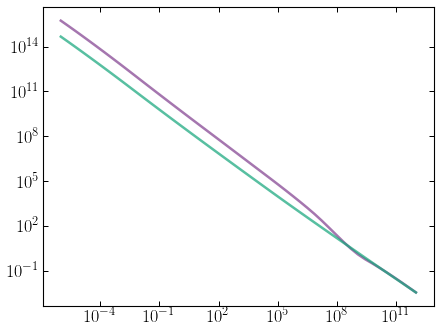

In [838]:
plt.plot(M_ary, dndlnM_ary)
plt.plot(M_ary, dndlnM_vanilla_ary)

plt.xscale("log")
plt.yscale("log")

## Densities

In [839]:
sig = Sigma(log10_P_interp)

In [840]:
# M = 1e4* M_s
# c200, zcoll = sig.c200_zcoll(M)

# rho_c * (200. / 3. / 4. * c200 ** 3 / (np.log(1 + c200) - c200 / (1 + c200))) / (M_s / pc ** 3)

In [841]:
# from scipy.optimize import fsolve
# M_calib = 1e12 * M_s
# C_calib = fsolve(lambda C: sig.c200_zcoll(M, C=C, f=0.02)[0] - pspecpop.c200_SCP(M), 1., xtol=0.2)[0]

In [843]:
M = 1e12 * M_s
print(pspecpop.c200_SCP(M))
print(sig.c200_zcoll(M, C=100., f=0.02)[0])

7.969815762591832
9.899473908342092


In [849]:
M_ary = np.logspace(8, 12, 10) * M_s
c200_ary = [sig.c200_zcoll(M, C=100.)[0] for M in tqdm_notebook(M_ary)]

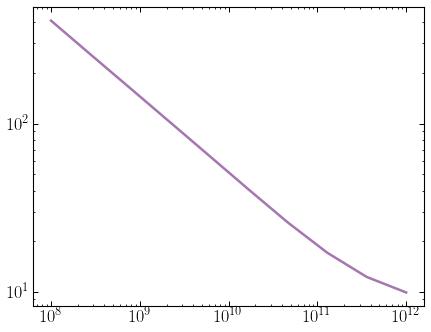

In [850]:
plt.plot(M_ary / M_s, c200_ary)
plt.xscale("log")
plt.yscale("log")

In [851]:
c200_interp = interp1d(np.log10(M_ary), np.log10(c200_ary), bounds_error=False, fill_value='extrapolate')

In [852]:
def dndM(M):
    return 10 ** dndlnM_interp(np.log10(M))
 
def c200_custom(M):
    return 10 ** c200_interp(np.log10(M))

In [853]:
c200_custom(1e-6 * M_s)

870523376.1258119

In [854]:
pspecpop = PowerSpectraPopulations(l_max=10000, n_l=20)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(dndM, M_min=1e-6 * M_s, M_max=0.01*1.1e12*M_s,
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=N_calib_new)
pspecpop.set_subhalo_properties(c200_custom)

In [855]:
C_l_mu_new = pspecpop.get_C_l_total_ary(l_los_min=pspecpop.l_cutoff)

In [856]:
C_l_alpha_new = pspecpop.get_C_l_total_ary(l_los_min=pspecpop.l_cutoff, accel=True)

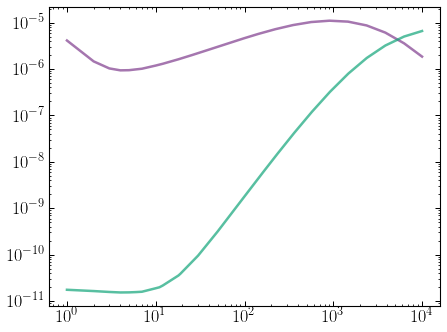

In [857]:
l_ary = np.arange(1, 10000)
plt.plot(l_ary, (1/(2*np.pi))*l_ary*(l_ary + 1)*C_l_mu_new)
plt.plot(l_ary, (1/(2*np.pi))*l_ary*(l_ary + 1)*C_l_alpha_new)

plt.xscale("log")
plt.yscale("log")

# plt.xlim(10, 1500)
# plt.ylim(1e-12,1e-4)

## Analyze cluster runs

In [7]:
# get_sens(C_l_mu_new, sigma_mu=10., N_q=1e7)

In [4]:
def get_sens(Cl_ary, sigma_mu=1., N_q=1e8):

    fDM_base = 1
    dfDM_base = 0.1

    Cl_ary_fid = Cl_ary*fDM_base

    p = Cl_ary*(fDM_base + dfDM_base)
    m = Cl_ary*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    None, None, '$\\f_\mathrm{DM}$' )

    parameters = [Cl_ary_fid, None, 1, 10000, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=10000, l_min_alpha=2, l_max_alpha=10000)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    baseline_sig = fDM_base/fshr.pars_vary[0].sigma
    return lim, baseline_sig

def get_sens_with_alpha(Cl_ary, Cl_ary_accel, f_sky=0.05, sigma_mu=10000., N_q_mu=1e8, sigma_alpha=1, N_q_alpha=1e12, l_min_mu=10, l_max_mu=2000, l_min_alpha=50, l_max_alpha=10000, l_max=10000):

    fDM_base = 1
    dfDM_base = 0.1

    Cl_ary_fid = np.array(Cl_ary)*fDM_base
    Cl_ary_accel_fid = np.array(Cl_ary_accel)*fDM_base

    p = np.array(Cl_ary)*(fDM_base + dfDM_base)
    m = np.array(Cl_ary)*(fDM_base - dfDM_base)

    p_a = np.array(Cl_ary_accel)*(fDM_base + dfDM_base)
    m_a = np.array(Cl_ary_accel)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    p_a, m_a, l_min=1, l_max=l_max)

    parameters = [Cl_ary_fid, Cl_ary_accel_fid, 1, l_max, fDM]
    
    observation = AstrometryObservation(fsky=f_sky, sigma_mu=sigma_mu, sigma_alpha=sigma_alpha, 
                                        N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                                        l_min_mu=l_min_mu, l_max_mu=l_max_mu, l_min_alpha=l_min_alpha, l_max_alpha=l_max_alpha)
    
    
    
    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    return lim, fDM_base/fshr.pars_vary[0].sigma

In [860]:
get_sens_with_alpha(C_l_mu_new, C_l_alpha_new, l_max=10000)

(0.014877842242150852, 110.23103843336017)

In [22]:
M_min = 1e1
n_B_ary = np.linspace(1, 3, 11)
k_B_ary = np.logspace(np.log10(5), np.log10(50), 11)

sens_ary = np.zeros((len(n_B_ary), len(k_B_ary)))

for i_n_B, n_B in enumerate((tqdm(n_B_ary))):
    for i_k_B, k_B in enumerate(k_B_ary):
        if not os.path.isfile("../cluster/cluster_out/wide_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) +  ".npz"): continue
        Cl_ary = np.load("../cluster/cluster_out/wide_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) + ".npz")['C_l_mu_new']
        sens_ary[i_n_B, i_k_B] = get_sens(Cl_ary)[1]

100%|██████████| 11/11 [01:12<00:00,  6.59s/it]


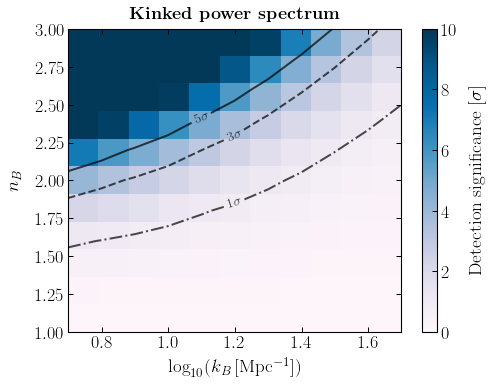

In [23]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
# levels = [0.1,0.2,5]

X, Y = np.meshgrid(np.log10(k_B_ary), n_B_ary)

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sens_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sens_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[np.log10(5),np.log10(50),1,3], vmin=0, vmax=10)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
ax.set_ylabel("$n_B$")
ax.set_title('\\textbf{Kinked power spectrum}', fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
# plt.savefig(plots_dir + "kink_PS_sig.pdf")

In [19]:
n_B_ary = np.linspace(2.25, 3, 11)
k_B_ary = np.logspace(np.log10(5), np.log10(50), 11)
M_min = 1e-6

sens_ary = np.zeros((len(n_B_ary), len(k_B_ary)))

for i_n_B, n_B in enumerate((tqdm(n_B_ary))):
    for i_k_B, k_B in enumerate(k_B_ary):
        if not os.path.isfile("../cluster/cluster_out/narrow_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) +  ".npz"): continue
        Cl_mu_ary = np.load("../cluster/cluster_out/narrow_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) + ".npz")['C_l_mu_new']
        Cl_alpha_ary = np.load("../cluster/cluster_out/narrow_" + str(k_B) + "_" + str(n_B) + "_" + str(M_min) + ".npz")['C_l_alpha_new']
        sens_ary[i_n_B, i_k_B] = get_sens_with_alpha(Cl_mu_ary, Cl_alpha_ary, sigma_mu=10000, sigma_alpha=.1, l_max=10000)[1]
        

100%|██████████| 11/11 [01:13<00:00,  6.77s/it]


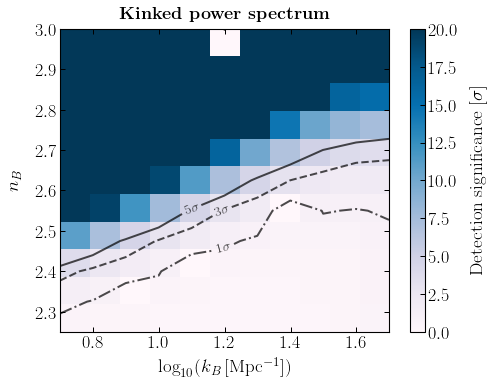

In [20]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
# levels = [0.1,0.2,5]

X, Y = np.meshgrid(np.log10(k_B_ary), n_B_ary)

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sens_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sens_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[np.log10(5),np.log10(50),2.25,3], vmin=0, vmax=20)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
ax.set_ylabel("$n_B$")
ax.set_title('\\textbf{Kinked power spectrum}', fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
# plt.savefig(plots_dir + "kink_PS_sig.pdf")

# plt.ylim(2, 3)

In [862]:
k_B = 3.
Cl_mu_ary = np.load("../cluster/cluster_out/calib2_6.294627058970836_3.0.npz")['C_l_mu_new']
Cl_alpha_ary = np.load("../cluster/cluster_out/calib2_6.294627058970836_3.0.npz")['C_l_alpha_new']
get_sens_with_alpha(Cl_mu_ary, Cl_alpha_ary, l_max=10000, sigma_alpha=1, N_q_alpha=1e12, sigma_mu=1000000)[1]

856.5903205683535